In [48]:
import os
import re
from copy import deepcopy
import json
import itertools

import numpy as np
import pandas as pd
from tqdm import tqdm

from rdkit import Chem
from rdkit.Chem import AllChem, Draw

In [80]:
building_blocks = pd.read_csv('building_blocks.csv', index_col=0)


def mol_from_seq(seq):
    rxn_link = AllChem.ReactionFromSmarts('[N:1]-[C:2]-[C:3](=[O:4])[O:5].[N:6]-[C:7]-[C:8]=[O:9]>>[N:1]-[C:2]-[C:3](=[O:4])-[N:6]-[C:7]-[C:8]=[O:9].[O:5]')
    rxn_ncap = AllChem.ReactionFromSmarts('[C:1](=[O:2])[O:3].[N:4]-[C:5]-[C:6]=[O:7]>>[C:1](=[O:2])-[N:4]-[C:5]-[C:6]=[O:7].[O:3]')
    rxn_ccap = AllChem.ReactionFromSmarts('[N:1]-[C:2]-[C:3](=[O:4])[O:5].[#7H1,#7H2,#7H3:6]>>[N:1]-[C:2]-[C:3](=[O:4])-[N:6].[O:5]')
    # Generic amide rxn
    rxn_general = AllChem.ReactionFromSmarts('[C:1](=[O:2])[O:3].[#7H1,#7H2,#7H3:4]>>[C:1](=[O:2])[N:4].[O:3]')
    
    for i in range(len(seq)):
        assert seq[i] in building_blocks.index, f'Unsupported residue: {seq[i]}'
        assert building_blocks.loc[seq[i], 'Category'] != 'other', f'Not amino-acid: {seq[i]}'
        if i == 0:
            product = Chem.MolFromSmiles(building_blocks.loc[seq[i], 'Smiles'])
            continue
        
        if i == 1 and building_blocks.loc[seq[0], 'Category'] == 'ncap':
            if building_blocks.loc[seq[i], 'Category'] == 'ccap':
                # ACE-NME cases
                rxn = rxn_general
            else:
                rxn = rxn_ncap
        elif i == len(seq) - 1 and building_blocks.loc[seq[i], 'Category'] == 'ccap':
            rxn = rxn_ccap
        else:
            rxn = rxn_link

        rxn_res = rxn.RunReactants((product, Chem.MolFromSmiles(building_blocks.loc[seq[i], 'Smiles'])))
        product = rxn_res[0][0]
        Chem.SanitizeMol(product)
    return product


def form_disulfide_bond(m):
    mnoh = Chem.RemoveHs(m)
    thiols = [match[0] for match in mnoh.GetSubstructMatches(Chem.MolFromSmarts('[SH:1]-[C:2]'))]
    results = []
    for i, j in itertools.combinations(thiols, 2):
        new_mol = Chem.RWMol(mnoh)
        new_mol.AddBond(i, j, Chem.BondType.SINGLE)
        new_mol.GetAtomWithIdx(i).SetNumExplicitHs(0)
        new_mol.GetAtomWithIdx(j).SetNumExplicitHs(0)
        mol = new_mol.GetMol()
        Chem.SanitizeMol(mol)
        results.append(mol)
    return results

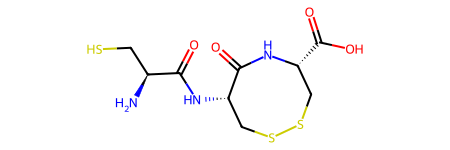

In [84]:
m = mol_from_seq(['CYS', 'CYS', 'CYS'])
form_disulfide_bond(m)[2]
# for atom in form_disulfide_bond(m)[0].GetAtoms():
#     if atom.GetSymbol() == 'S':
#         print(atom.GetNumExplicitHs(), atom.GetNumImplicitHs())

In [17]:
import pandas as pd
from rcsb import get_smiles_from_rcsb
from tqdm import tqdm

df = pd.read_csv('short_chain.csv')
ccds = set()
for names in df['pdb_seq'].str.split():
    if not isinstance(names, list):
        continue
    ccds = ccds.union(names)

for names in df['resnames'].str.split():
    if not isinstance(names, list):
        continue
    ccds = ccds.union(names)

smi = {ccd: get_smiles_from_rcsb(ccd) for ccd in tqdm(ccds)}

100%|██████████| 730/730 [02:33<00:00,  4.74it/s]


In [22]:
smi['NH2'] = 'N'
smi['ACE'] = 'CC(=O)O'
amino_acid_patt = Chem.MolFromSmarts('NCC(=O)O')
ccap_patt = Chem.MolFromSmarts('[#7H1,#7H2,#7H3]')
ncap_patt = Chem.MolFromSmarts('C(=O)O')

amino_acids = []
ccaps = []
ncaps = []

category = {}
for ccd in smi:
    if not smi[ccd]:
        continue
    mol = Chem.MolFromSmiles(smi[ccd])
    if mol is None:
        continue

    num_ccaps = len(mol.GetSubstructMatches(ccap_patt))
    num_ncaps = len(mol.GetSubstructMatches(ncap_patt))

    if len(mol.GetSubstructMatches(amino_acid_patt)) == 1:
        amino_acids.append(ccd)
        category[ccd] = 'aa'
    elif num_ccaps == 1 and num_ncaps == 0:
        ccaps.append(ccd)
        category[ccd] = 'ccap'
    elif num_ncaps == 1 and num_ccaps == 0:
        ncaps.append(ccd)
        category[ccd] = 'ncap'
    else:
        category[ccd] = 'other'

In [41]:
df = pd.DataFrame([category, smi]).T
df.insert(0, 'CCD', df.index)
df.columns = ['CCD', 'Category', 'Smiles']
df.to_csv('amino_acids.csv', sep=',', index=None)

In [47]:
df = pd.read_csv('amino_acids.csv', index_col=0)
df.to_dict(orient='index')

{'AMM': {'Category': 'ccap', 'Smiles': 'CC(C)C[C@H](C[Si](CN)(O)O)C=O'},
 'DH6': {'Category': 'ccap', 'Smiles': 'c1ccc(cc1)/C=C/C(=O)N'},
 '56A': {'Category': 'aa',
  'Smiles': 'c1ccc(cc1)CCCCCCCCn2cncc2C[C@@H](C(=O)O)N'},
 '39Y': {'Category': 'ncap', 'Smiles': 'CC[C@H](C)C/C=C/C(=O)O'},
 'AHY': {'Category': 'other', 'Smiles': 'CCCCCCC[C@H]([C@@H](C(=O)O)O)N'},
 'MTN': {'Category': 'other', 'Smiles': 'CC1(C=C(C(N1[O])(C)C)CSS(=O)(=O)C)C'},
 '7D1': {'Category': 'other', 'Smiles': 'C1CO[C@@H]([C@H]([C@@H]1O)O)CO'},
 '73C': {'Category': 'aa', 'Smiles': 'CCCCOC[C@@H](C(=O)O)N'},
 'DHR': {'Category': 'other', 'Smiles': 'c1cc(ccc1[C@@H](C#N)O)O'},
 'QSC': {'Category': 'ccap', 'Smiles': 'C[C@H](c1ccccc1)N'},
 'OBF': {'Category': 'aa', 'Smiles': 'C([C@@H](C(=O)O)N)C(F)F'},
 'LPD': {'Category': 'other', 'Smiles': 'C1C[C@H](NC1)C(=O)N'},
 '3CU': {'Category': 'other',
  'Smiles': 'C1[C@@H]([C@H]([C@H]2[N@@]1[C@@H]([C@H]([C@@H]2O)O)CO)O)O'},
 '8EX': {'Category': 'ccap',
  'Smiles': 'CC(=O)N[C@@H]1